<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li>

# Отток клиентов

В нашем распоряжении исторические данные о поведении клиентов и расторжении договоров с банком. 
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. 

Необходимо построить модель довкдя метрику F1 до 0.59.

Дополнительно измеряем *AUC-ROC*, сравним её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv('/datasets/Churn.csv')

In [3]:
display(data)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


Поменяем все буквы в названиях столбцов на строчные

In [4]:
data.columns=data.columns.str.lower()

Переименуем названия столбцов в удобный нам вид

In [5]:
data.rename(columns={'rownumber': 'row_number', 'customerid': 'customer_id', 'creditscore': 'credit_score', 'numofproducts': 'num_of_products', 'hascrcard': 'has_cr_card', 'isactivemember': 'is_active_member', 'estimatedsalary': 'estimated_salary'}, inplace=True)

In [6]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            9091 non-null   float64
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None


In [7]:
print(data.isnull().sum())

row_number            0
customer_id           0
surname               0
credit_score          0
geography             0
gender                0
age                   0
tenure              909
balance               0
num_of_products       0
has_cr_card           0
is_active_member      0
estimated_salary      0
exited                0
dtype: int64


Обнаружили 909 пропусков, есть подозрения, что NaNы это люди, которые являются клиентами банка меньше года

In [8]:
data[data['tenure']==0].count()

row_number          382
customer_id         382
surname             382
credit_score        382
geography           382
gender              382
age                 382
tenure              382
balance             382
num_of_products     382
has_cr_card         382
is_active_member    382
estimated_salary    382
exited              382
dtype: int64

Предположение не подтвердилось

In [9]:
data[data.isnull().any(1)]

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,9945,15703923,Cameron,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,9957,15707861,Nucci,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,9965,15642785,Douglas,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,9986,15586914,Nepean,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


In [10]:
data['tenure']=data['tenure'].fillna(data['tenure'].median())

In [11]:
print(data.isnull().sum())

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64


Пропуски заполним медианным значением по столбцу

In [12]:
data.nunique()

row_number          10000
customer_id         10000
surname              2932
credit_score          460
geography               3
gender                  2
age                    70
tenure                 11
balance              6382
num_of_products         4
has_cr_card             2
is_active_member        2
estimated_salary     9999
exited                  2
dtype: int64

Id пользователей уникальны, повторов нет.

In [13]:
data[data['estimated_salary'].duplicated()==True]

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
3620,3621,15763806,Astorga,773,France,Male,41,4.0,0.0,2,1,1,24924.92,0


In [14]:
data[data['customer_id']==15763806]

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
3620,3621,15763806,Astorga,773,France,Male,41,4.0,0.0,2,1,1,24924.92,0


In [15]:
data[data['estimated_salary']==24924.92]

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
3176,3177,15613014,Hs?,722,Germany,Male,29,1.0,107233.85,2,1,0,24924.92,0
3620,3621,15763806,Astorga,773,France,Male,41,4.0,0.00,2,1,1,24924.92,0


Увидев дубликат в солбце estimated_salary, мы обнаружили строку с значением в столбце surname, - 'Hs?'

In [16]:
data[data['surname'].str.contains('\\?')==True]

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0
329,330,15624528,L?,664,Germany,Male,26,5.0,116244.14,2,1,1,95145.14,0
437,438,15624623,Hs?,516,France,Male,35,10.0,104088.59,2,0,0,119666.00,0
941,942,15676521,Y?an,696,France,Female,31,8.0,0.00,2,0,0,191074.11,0
970,971,15805955,L?,638,France,Female,48,10.0,138333.03,1,1,1,47679.14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9633,9634,15668057,K?,669,France,Female,31,6.0,113000.66,1,1,0,40467.82,0
9704,9705,15759872,L?,625,France,Male,22,9.0,0.00,2,1,0,157072.91,0
9792,9793,15787168,Y?,819,Spain,Female,28,8.0,168253.21,1,1,1,102799.14,0
9857,9858,15779423,K?,716,France,Male,39,1.0,70657.61,2,1,1,76476.05,0


Скорее всего данные записаны неверно оператором, или ошибка какая

In [17]:
data.describe()

,row_number,customer_id,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.99790,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.76001,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.00000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.00000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.00000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.00000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.00000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Теперь необходимо искоючить столбцы, не учавствующие в исследовании, а такжеразбить датасет на выборки

In [18]:
data=data.drop(['row_number', 'customer_id', 'surname'], axis=1)

In [19]:
data.corr()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
credit_score,1.000000,-0.003965,-0.000060,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
age,-0.003965,1.000000,-0.012606,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
tenure,-0.000060,-0.012606,1.000000,-0.007535,0.011409,0.025979,-0.030681,0.010049,-0.015989
balance,0.006268,0.028308,-0.007535,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
num_of_products,0.012238,-0.030680,0.011409,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
has_cr_card,-0.005458,-0.011721,0.025979,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
is_active_member,0.025651,0.085472,-0.030681,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
estimated_salary,-0.001384,-0.007201,0.010049,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
exited,-0.027094,0.285323,-0.015989,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


Зависимость признаков друг от друга маленькая. Наибольшая зависимость между age и exited с значением 0.28

<AxesSubplot:xlabel='age'>

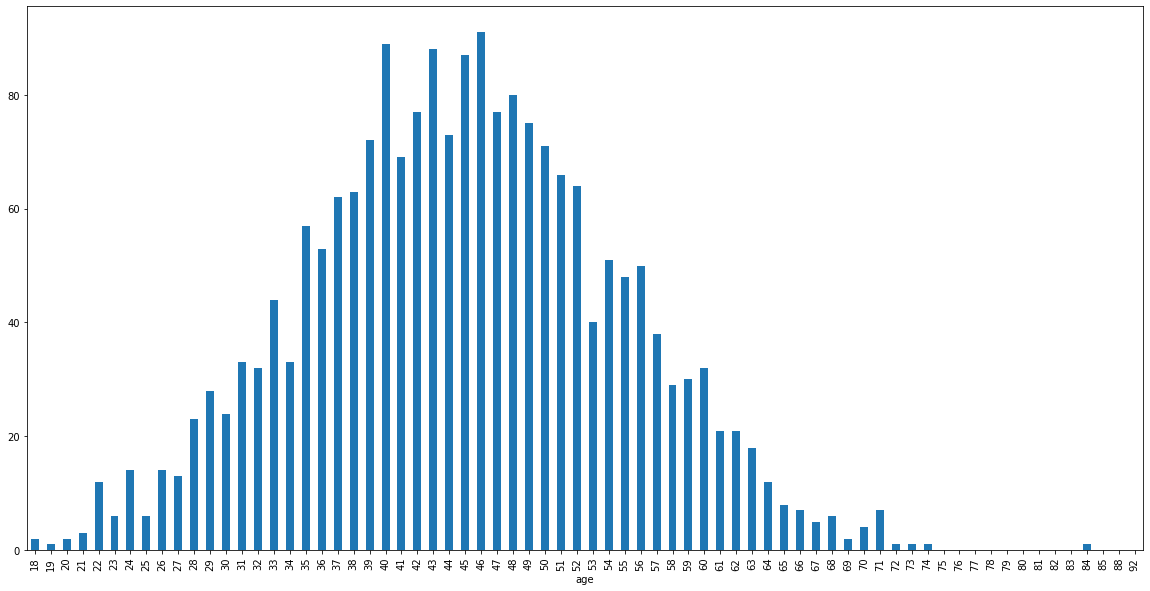

In [20]:
data.groupby('age')['exited'].sum().plot(kind='bar', figsize=(20,10))

Теперь необходимо перевести категориальные признаки в количественные с помощью метода ohe.

In [21]:
categori_columns = ['geography', 'gender']
data_ohe = pd.get_dummies(data, drop_first = True, columns=categori_columns)

In [22]:
display(data_ohe)

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5.0,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10.0,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7.0,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3.0,75075.31,2,1,0,92888.52,1,1,0,1


In [23]:
data_ohe.columns=data_ohe.columns.str.lower()

In [24]:
data_train, data_valid = train_test_split(data_ohe, test_size=0.4, random_state=1)
data_valid, data_test = train_test_split(data_valid, test_size=0.5, random_state=1)
features_train=data_train.drop(['exited'], axis=1)
target_train=data_train['exited']
features_valid=data_valid.drop(['exited'], axis=1)
target_valid=data_valid['exited']
features_test=data_test.drop(['exited'], axis=1)
target_test=data_test['exited']

In [25]:
numeric = ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric]) 
features_test[numeric] = scaler.transform(features_test[numeric]) 

На этом пока что закончим подготовку данных.
Найдены фамилии, в которых присутствует символ "?".
Обнаружениы 909 пропусков в столбце tenure и заполнены медианным значением по столбцу.
Изменены названия столбцов.
Удалены ненужные столбцы.
Выявлена небольшая зависимость age и exited. Наибольший отток клиентов выявлен в возрасте от 40 до 50 лет.
Категориальные данные переведены в количественные.
Был обнаружен большой разброс значений признаков, принято решение масштабировать их.

## Исследование задачи

Исследуйте баланс классов, обучите модель без учёта дисбаланса. Кратко опишите выводы.

In [26]:
best_model_tree = None
best_result_tree = 0
for depth in range(1,10):
    model_tree = DecisionTreeClassifier(random_state=1, max_depth=depth)
    model_tree.fit(features_train, target_train)
    predictions_valid_tree = model_tree.predict(features_valid)
    result_tree = f1_score(target_valid, predictions_valid_tree)
    print(result_tree)
    probabilities_valid = model_tree.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc_tree_simple=roc_auc_score(target_valid,probabilities_one_valid)
    if result_tree>best_result_tree:
        best_model_tree = model_tree
        best_result_tree = result_tree
print("F1 лучшей модели tree:", best_result_tree, ", при параметре max_depth =",depth, ', auc_roc равен', auc_roc_tree_simple)

print('*********************************************************************************************************')
best_model_forest = None
best_result_forest = 0
for est in range(30, 50, 4):
     for depth in range(15,20,1):
        model_forest = RandomForestClassifier(random_state=1, n_estimators=est, max_depth=depth) 
        model_forest.fit(features_train,target_train) 
        predictions_valid_forest = model_forest.predict(features_valid)
        result_forest = f1_score(target_valid, predictions_valid_forest) 
        print(result_forest)
        probabilities_valid = model_forest.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc_forest_simple=roc_auc_score(target_valid,probabilities_one_valid)
        if result_forest > best_result_forest:
            best_model_forest = model_forest
            best_result_forest = result_forest
print("F1 наилучшей модели forest:", best_result_forest, ", при параметре n_estimators =",est, ',при параметре max_depth =',depth, ', auc_roc равен', auc_roc_forest_simple )

print('*********************************************************************************************************')
best_model_logistict = None
best_result_logistic = 0
solver=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
for solver in solver:
    model_logistic = LogisticRegression(random_state=1, solver=solver, max_iter=1000)
    model_logistic.fit(features_train,target_train) 
    predictions_valid_logistic = model_logistic.predict(features_valid)
    result_logistic = f1_score(target_valid, predictions_valid_logistic) 
    print(result_logistic,solver)
    probabilities_valid = model_logistic.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc_logistic_simple=roc_auc_score(target_valid,probabilities_one_valid)
    if result_logistic > best_result_logistic:
        best_model_logistic = model_logistic
        best_result_logistic = result_logistic
print("F1 наилучшей модели logistic:", best_result_logistic, ", при параметре solver = ",solver, ', auc_roc равен', auc_roc_logistic_simple )

0.0
0.5278911564625851
0.39194139194139194
0.5319148936170213
0.5171849427168577
0.5970588235294118
0.6037735849056604
0.611413043478261
0.5659340659340659
F1 лучшей модели tree: 0.611413043478261 , при параметре max_depth = 9 , auc_roc равен 0.785905869645992
*********************************************************************************************************
0.6081871345029239
0.6046511627906976
0.5832106038291606
0.5804511278195489
0.5991316931982633
0.5949926362297496
0.6014598540145986
0.5873715124816447
0.5774436090225564
0.6005830903790088
0.58493353028065
0.5988372093023256
0.5941176470588234
0.5901639344262295
0.6032210834553441
0.5837037037037037
0.5973645680819911
0.5920471281296023
0.5943536404160475
0.6005830903790088
0.5929203539823009
0.597667638483965
0.5911764705882353
0.5952380952380951
0.6120058565153734
F1 наилучшей модели forest: 0.6120058565153734 , при параметре n_estimators = 46 ,при параметре max_depth = 19 , auc_roc равен 0.8535476766768106
***************

При переборе гиперпараметров, F1 наилучшей модели forest: 0.583 , при параметре n_estimators = 46 ,при параметре max_depth = 19. Худшая модель - LogisticRegression с значением F1 = 0.295.

## Борьба с дисбалансом

Преобразуем выборку методом увеличения данных.
Разделяем обучающую выборку на отрицательные и положительные объекты;
Скопируем несколько раз положительные объекты;
С учётом полученных данных создаем новую обучающую выборку;
Перемешиваем данные, в данном случае, 10 раз.

In [27]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

Преобразуем выборку методом уменьшения данных
Разделим обучающую выборку на отрицательные и положительные объекты;
Случайным образом отбросим часть из отрицательных объектов;
С учётом полученных данных создадим новую обучающую выборку;
Перемешаем данные.

In [28]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

Решил выбрать метод увеличения данных

Теперь протестируем модель на выборке, применив метод upsample

In [29]:
%%time
best_model_tree_up = None
best_result_tree_up = 0
for depth in range(1,10):
    model_tree_up = DecisionTreeClassifier(random_state=1, max_depth=depth)
    model_tree_up.fit(features_upsampled, target_upsampled)
    predictions_valid_tree_up = model_tree_up.predict(features_valid)
    result_tree_up = f1_score(target_valid, predictions_valid_tree_up)
    if result_tree>best_result_tree_up:
        best_model_tree_up = model_tree_up
        best_result_tree_up = result_tree_up
print("F1 лучшей модели tree:", best_result_tree_up, ", при параметре max_depth =",depth )
probabilities_valid_tree_up = best_model_tree_up.predict_proba(features_valid)
probabilities_one_valid_tree_up = probabilities_valid_tree_up[:, 1]
auc_roc_tree_up=roc_auc_score(target_valid,probabilities_one_valid_tree_up)
print('AUC-ROC модели дерева решений', auc_roc_tree_up)

F1 лучшей модели tree: 0.5053598774885145 , при параметре max_depth = 9
AUC-ROC модели дерева решений 0.7930340168391854
CPU times: user 413 ms, sys: 0 ns, total: 413 ms
Wall time: 412 ms


In [30]:
%%time
best_model_forest_up = None
best_result_forest_up = 0
for est in range(30, 50, 4):
     for depth in range(15,20,1):
        model_forest_up = RandomForestClassifier(random_state=1, n_estimators=est, max_depth=depth) 
        model_forest_up.fit(features_upsampled, target_upsampled) 
        predictions_valid_forest_up = model_forest_up.predict(features_valid)
        result_forest_up = f1_score(target_valid, predictions_valid_forest_up) 
        if result_forest_up > best_result_forest_up:
            best_model_forest_up = model_forest_up
            best_result_forest_up = result_forest_up
print("F1 наилучшей модели forest:", best_result_forest_up, ", при параметре n_estimators =",est, ',при параметре max_depth =',depth )
probabilities_valid_forest_up = best_model_forest_up.predict_proba(features_valid)
probabilities_one_valid_forest_up = probabilities_valid_forest_up[:, 1]
auc_roc_forest_up=roc_auc_score(target_valid,probabilities_one_valid_forest_up)
print('AUC-ROC модели случайного дерева', auc_roc_forest_up)

F1 наилучшей модели forest: 0.615 , при параметре n_estimators = 46 ,при параметре max_depth = 19
AUC-ROC модели случайного дерева 0.8571707942276826
CPU times: user 26.5 s, sys: 29.5 ms, total: 26.5 s
Wall time: 26.9 s


In [31]:
%%time
best_model_logistict_up = None
best_result_logistic_up = 0
solver=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
for solver in solver:
    model_logistic_up = LogisticRegression(random_state=1, solver=solver, max_iter=1000)
    model_logistic_up.fit(features_upsampled, target_upsampled) 
    predictions_valid_logistic_up = model_logistic_up.predict(features_valid)
    result_logistic_up = f1_score(target_valid, predictions_valid_logistic_up) 
    if result_logistic_up > best_result_logistic_up:
        best_model_logistic_up = model_logistic_up
        best_result_logistic_up = result_logistic_up
print("F1 наилучшей модели logistic:", best_result_logistic_up, ", при параметре solver = ",solver)
probabilities_valid_logistic_up = best_model_logistic_up.predict_proba(features_valid)
probabilities_one_valid_logistic_up = probabilities_valid_logistic_up[:, 1]
auc_roc_logistic_up=roc_auc_score(target_valid,probabilities_one_valid_logistic_up)
print('AUC-ROC модели логистической регрессии', auc_roc_logistic_up)

F1 наилучшей модели logistic: 0.4259055982436883 , при параметре solver =  saga
AUC-ROC модели логистической регрессии 0.7772591269918873
CPU times: user 2.11 s, sys: 1.85 s, total: 3.97 s
Wall time: 4.02 s


Теперь протестируем модель на выборке, применив метод downsample

In [32]:
%%time
best_model_tree_down = None
best_result_tree_down = 0
for depth in range(1,10):
    model_tree_down = DecisionTreeClassifier(random_state=1, max_depth=depth)
    model_tree_down.fit(features_downsampled, target_downsampled)
    predictions_valid_tree_down = model_tree_down.predict(features_valid)
    result_tree_down = f1_score(target_valid, predictions_valid_tree_down)
    if result_tree_down>best_result_tree_down:
        best_model_tree_down = model_tree_down
        best_result_tree_down = result_tree_down
print("F1 лучшей модели tree:", best_result_tree_down, ", при параметре max_depth =",depth )
probabilities_valid_tree_down = best_model_tree_down.predict_proba(features_valid)
probabilities_one_valid_tree_down = probabilities_valid_tree_down[:, 1]
auc_roc_tree_down=roc_auc_score(target_valid,probabilities_one_valid_tree_down)
print('AUC-ROC модели дерева решений', auc_roc_tree_down)

F1 лучшей модели tree: 0.49644381223328593 , при параметре max_depth = 9
AUC-ROC модели дерева решений 0.7827836855161043
CPU times: user 148 ms, sys: 27.9 ms, total: 176 ms
Wall time: 238 ms


In [33]:
%%time
best_model_forest_down = None
best_result_forest_down = 0
for est in range(30, 50, 4):
     for depth in range(15,20,1):
        model_forest_down = RandomForestClassifier(random_state=1, n_estimators=est, max_depth=depth) 
        model_forest_down.fit(features_downsampled, target_downsampled) 
        predictions_valid_forest_down = model_forest_down.predict(features_valid)
        result_forest_down = f1_score(target_valid, predictions_valid_forest_down) 
        if result_forest_down > best_result_forest_down:
            best_model_forest_down = model_forest_down
            best_result_forest_down = result_forest_down
print("F1 наилучшей модели forest:", best_result_forest_down, ", при параметре n_estimators =",est, ',при параметре max_depth =',depth )
probabilities_valid_forest_down = best_model_forest_down.predict_proba(features_valid)
probabilities_one_valid_forest_down = probabilities_valid_forest_down[:, 1]
auc_roc_forest_down=roc_auc_score(target_valid,probabilities_one_valid_forest_down)
print('AUC-ROC модели случайного дерева', auc_roc_forest_down)

F1 наилучшей модели forest: 0.48749198203976907 , при параметре n_estimators = 46 ,при параметре max_depth = 19
AUC-ROC модели случайного дерева 0.8302347166416701
CPU times: user 5.39 s, sys: 32.5 ms, total: 5.42 s
Wall time: 5.67 s


In [34]:
%%time
best_model_logistict_down = None
best_result_logistic_down = 0
solver=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
for solver in solver:
    model_logistic_down = LogisticRegression(random_state=1, solver=solver, max_iter=1000)
    model_logistic_down.fit(features_downsampled, target_downsampled) 
    predictions_valid_logistic_down = model_logistic_down.predict(features_valid)
    result_logistic_down = f1_score(target_valid, predictions_valid_logistic_down) 
    if result_logistic_down > best_result_logistic_down:
        best_model_logistic_down = model_logistic_down
        best_result_logistic_down = result_logistic_down
print("F1 наилучшей модели logistic:", best_result_logistic_down, ", при параметре solver = ",solver)
probabilities_valid_logistic_down = best_model_logistic_down.predict_proba(features_valid)
probabilities_one_valid_logistic_down = probabilities_valid_logistic_down[:, 1]
auc_roc_logistic_down=roc_auc_score(target_valid,probabilities_one_valid_logistic_down)
print('AUC-ROC модели логистической регрессии', auc_roc_logistic_down)

F1 наилучшей модели logistic: 0.4290465631929046 , при параметре solver =  saga
AUC-ROC модели логистической регрессии 0.7741512337553911
CPU times: user 1.29 s, sys: 1.59 s, total: 2.88 s
Wall time: 2.87 s


Продолжим применять методы борьбы с дисбалансом. Применим метод взвешивания классов.

In [35]:
%%time
best_model_tree_blnc = None
best_result_tree_blnc = 0
for depth in range(1,10):
    model_tree_blnc = DecisionTreeClassifier(random_state=1, max_depth=depth,class_weight='balanced')
    model_tree_blnc.fit(features_train, target_train)
    predictions_valid_tree_blnc = model_tree_blnc.predict(features_valid)
    result_tree_blnc = f1_score(target_valid, predictions_valid_tree_blnc)
    if result_tree_blnc>best_result_tree_blnc:
        best_model_tree_blnc = model_tree_blnc
        best_result_tree_blnc = result_tree_blnc
print("F1 лучшей модели tree:", best_result_tree_blnc, ", при параметре max_depth =",depth )
probabilities_valid_tree_blnc = best_model_tree_blnc.predict_proba(features_valid)
probabilities_one_valid_tree_blnc = probabilities_valid_tree_blnc[:, 1]
auc_roc_tree_blnc=roc_auc_score(target_valid,probabilities_one_valid_tree_blnc)
print('AUC-ROC модели дерева решений', auc_roc_tree_blnc)

F1 лучшей модели tree: 0.5907407407407407 , при параметре max_depth = 9
AUC-ROC модели дерева решений 0.8388491167475731
CPU times: user 251 ms, sys: 11.5 ms, total: 262 ms
Wall time: 268 ms


In [36]:
%%time
best_model_forest_blnc = None
best_result_forest_blnc = 0
for est in range(30, 50, 4):
     for depth in range(15,20,1):
        model_forest_blnc = RandomForestClassifier(random_state=1, n_estimators=est, max_depth=depth,class_weight='balanced') 
        model_forest_blnc.fit(features_train, target_train) 
        predictions_valid_forest_blnc = model_forest_blnc.predict(features_valid)
        result_forest_blnc = f1_score(target_valid, predictions_valid_forest_blnc) 
        if result_forest_blnc > best_result_forest_blnc:
            best_model_forest_blnc = model_forest_blnc
            best_result_forest_blnc = result_forest_blnc
print("F1 наилучшей модели forest:", best_result_forest_blnc, ", при параметре n_estimators =",est, ',при параметре max_depth =',depth )
probabilities_valid_forest_blnc = best_model_forest_blnc.predict_proba(features_valid)
probabilities_one_valid_forest_blnc = probabilities_valid_forest_blnc[:, 1]
auc_roc_forest_blnc=roc_auc_score(target_valid,probabilities_one_valid_forest_blnc)
print('AUC-ROC модели случайного дерева', auc_roc_forest_blnc)

F1 наилучшей модели forest: 0.6052631578947367 , при параметре n_estimators = 46 ,при параметре max_depth = 19
AUC-ROC модели случайного дерева 0.8547729327470557
CPU times: user 12.2 s, sys: 33.8 ms, total: 12.3 s
Wall time: 13 s


In [37]:
%%time
best_model_logistict_blnc = None
best_result_logistic_blnc = 0
solver=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
for solver in solver:
    model_logistic_blnc = LogisticRegression(random_state=1, solver=solver, max_iter=1000,class_weight='balanced')
    model_logistic_blnc.fit(features_train, target_train) 
    predictions_valid_logistic_blnc = model_logistic_blnc.predict(features_valid)
    result_logistic_blnc = f1_score(target_valid, predictions_valid_logistic_blnc) 
    if result_logistic_blnc > best_result_logistic_blnc:
        best_model_logistic_blnc = model_logistic_blnc
        best_result_logistic_blnc = result_logistic_blnc
print("F1 наилучшей модели logistic:", best_result_logistic_blnc, ", при параметре solver = ",solver)
probabilities_valid_logistic_blnc = best_model_logistic_blnc.predict_proba(features_valid)
probabilities_one_valid_logistic_blnc = probabilities_valid_logistic_blnc[:, 1]
auc_roc_logistic_blnc=roc_auc_score(target_valid,probabilities_one_valid_logistic_blnc)
print('AUC-ROC модели логистической регрессии', auc_roc_logistic_blnc)

F1 наилучшей модели logistic: 0.5080713678844521 , при параметре solver =  saga
AUC-ROC модели логистической регрессии 0.7759774595003603
CPU times: user 1.03 s, sys: 1.13 s, total: 2.16 s
Wall time: 2.17 s


Приментив 3 метода борьбы с дисбалансом на трех моделях, выявлена лучшая модель случайного леса, полученная с помощью метода увеличения тестовой выборки.
F1 наилучшей модели forest: 0.615 , при параметре n_estimators = 46 ,при параметре max_depth = 19
AUC-ROC модели случайного дерева 0.8571707942276826
CPU times: user 20.6 s, sys: 4.58 ms, total: 20.6 s
Wall time: 21 s

## Тестирование модели

Протестируем лучшую модель на тестовой выборке.

In [41]:
%%time
model_forest_test = RandomForestClassifier(random_state=1, n_estimators=46, max_depth=19) 
model_forest_test.fit(features_upsampled, target_upsampled) 
predictions_forest_test = model_forest_test.predict(features_test)
result_forest_test = f1_score(target_test, predictions_forest_test) 
print("F1 наилучшей тестовой forest:", result_forest_test, ", при параметре n_estimators =",est, ',при параметре max_depth =',depth )
probabilities_forest_test = model_forest_test.predict_proba(features_test)
probabilities_one_forest_test = probabilities_forest_test[:, 1]
auc_roc_forest_test=roc_auc_score(target_test,probabilities_one_forest_test)
print('AUC-ROC тестовой модели случайного дерева', auc_roc_forest_test)

F1 наилучшей тестовой forest: 0.6143437077131259 , при параметре n_estimators = 46 ,при параметре max_depth = 19
AUC-ROC тестовой модели случайного дерева 0.8529279686558168
CPU times: user 1.36 s, sys: 1.68 ms, total: 1.36 s
Wall time: 1.36 s


Финальная сравнительная таблица результатов моделей

In [42]:
status = pd.DataFrame([['tree', best_result_tree,     auc_roc_tree_simple,     best_result_tree_up,     auc_roc_tree_up,     best_result_tree_down,     auc_roc_tree_down,     best_result_tree_blnc,     auc_roc_tree_blnc],
                  ['forest',    best_result_forest,   auc_roc_forest_simple,   best_result_forest_up,   auc_roc_forest_up,   best_result_forest_down,   auc_roc_forest_down,   best_result_forest_blnc,   auc_roc_forest_blnc,  result_forest_test, auc_roc_forest_test],
                  ['logistic',  best_result_logistic, auc_roc_logistic_simple, best_result_logistic_up, auc_roc_logistic_up, best_result_logistic_down, auc_roc_logistic_down, best_result_logistic_blnc, auc_roc_logistic_blnc]],
columns=['model','result_F1_simple', 'auc_roc_simple', 'result_F1_up', 'auc_roc_up','result_F1_down','auc_roc_down','result_F1_blnc','auc_roc_blnc','result_F1_test','auc_roc_test'])
status.sort_values('result_F1_test', ascending=False).reset_index(drop=True)

,model,result_F1_simple,auc_roc_simple,result_F1_up,auc_roc_up,result_F1_down,auc_roc_down,result_F1_blnc,auc_roc_blnc,result_F1_test,auc_roc_test
0,forest,0.612006,0.853548,0.615000,0.857171,0.487492,0.830235,0.605263,0.854773,0.614344,0.852928
1,tree,0.611413,0.785906,0.505360,0.793034,0.496444,0.782784,0.590741,0.838849,NaN,NaN
2,logistic,0.325664,0.771595,0.425906,0.777259,0.429047,0.774151,0.508071,0.775977,NaN,NaN


## Вывод

Протестировав разные модели с различными гиперпараметрами и методами баланса класснов, по метрике F1, равной 0.615 на валидационной выборке и методом увеличения тренировочной выборки, была протестирована тестовая выборка. По результатам теста мы получили F1 = 0.614, AUC-ROC = 0.853.
AUC-ROC говорит об отличии от случайной модели и средней доли истинно положительных ответов.